# 1. 大模型推理

## 2.1. transformers大模型推理基础模式

- **大模型与大模型加载**

- 下载的大模型文件主要由三个部分构成：
    > 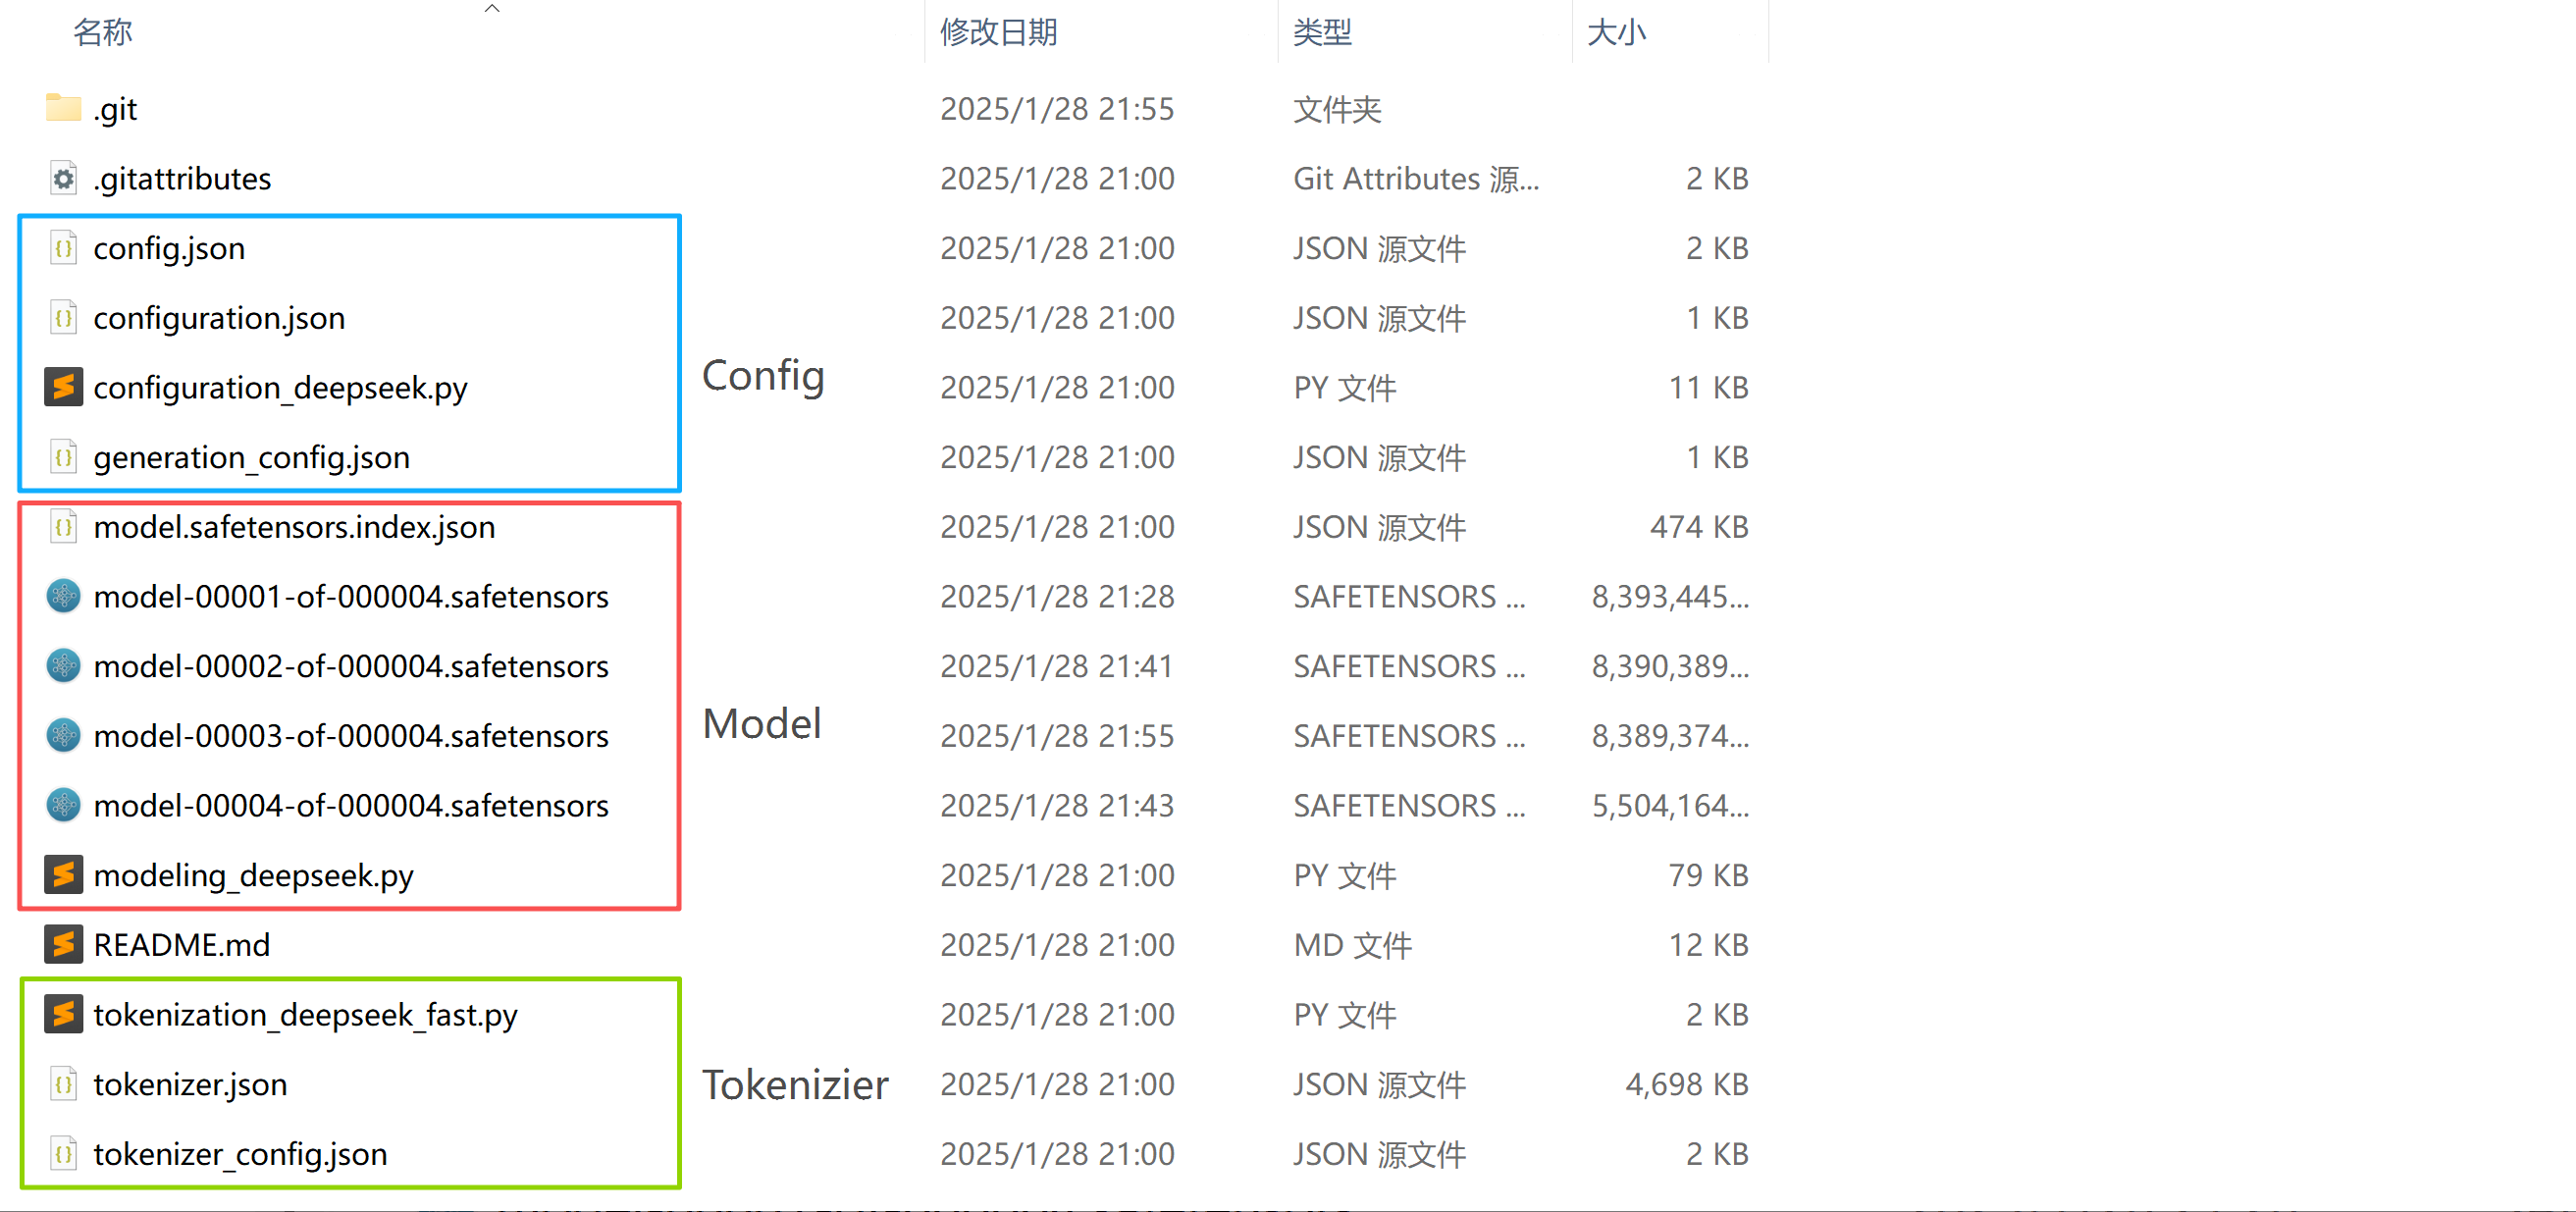

- 在transformers中这三块数据的加载由三个对象负责（类）
    - AutoConfig
        - from_pretrained从大模型中加载配置
    - AutoModel(或者AutoModelForCausalLM)：模型加载下面二选一。
        - from_pretrained直接从大模型文件加载模型。
        - from_config从Autoconfig对象加载模型。
    - AutoTokenizer
        - from_pretrained直接从大模型文件加载分词器（包含词袋/词表/字典）

- **案例**：大模型文件加载例子

In [1]:
import torch
from transformers import AutoConfig

config = AutoConfig.from_pretrained("D:/DeepSeek/DeepSeek-Coder-V2-Lite-Instruct", trust_remote_code=True)  # 不用过多关注函数更多的参数使用。
config   # 把输出的配置与大模型中的配置文件内容进行比较，可以看出加载本身就是一个文件读取与数据解析的过程。

DeepseekV2Config {
  "_name_or_path": "D:/DeepSeek/DeepSeek-Coder-V2-Lite-Instruct",
  "architectures": [
    "DeepseekV2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "configuration_deepseek.DeepseekV2Config",
    "AutoModel": "modeling_deepseek.DeepseekV2Model",
    "AutoModelForCausalLM": "modeling_deepseek.DeepseekV2ForCausalLM"
  },
  "aux_loss_alpha": 0.001,
  "bos_token_id": 100000,
  "eos_token_id": 100001,
  "ep_size": 1,
  "first_k_dense_replace": 1,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 10944,
  "kv_lora_rank": 512,
  "max_position_embeddings": 163840,
  "model_type": "deepseek_v2",
  "moe_intermediate_size": 1408,
  "moe_layer_freq": 1,
  "n_group": 1,
  "n_routed_experts": 64,
  "n_shared_experts": 2,
  "norm_topk_prob": false,
  "num_attention_heads": 16,
  "num_experts_per_tok": 6,
  "num_hidden_layers": 27,
  "num_key_value_heads": 16,
  "pretraining_

- 代码与运行说明
    - 因为transformers中提供的是通用API，是对接口的实现实际大模型的实现可以是个性化的，其真正的实现类通过"auto_map"来映射：
        -  > **"AutoConfig"**: "configuration_deepseek.DeepseekV2Config",
        -  > **"AutoModel"**: "modeling_deepseek.DeepseekV2Model",
        -  > **"AutoModelForCausalLM"**: "modeling_deepseek.DeepseekV2ForCausalLM"
    - Config的其他配置在后面随着讲解的深入，逐步解释。

In [1]:
import torch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained("D:/DeepSeek/DeepSeek-Coder-V2-Lite-Instruct", trust_remote_code=True, torch_dtype=torch.bfloat16)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [2]:
model

DeepseekV2ForCausalLM(
  (model): DeepseekV2Model(
    (embed_tokens): Embedding(102400, 2048)
    (layers): ModuleList(
      (0): DeepseekV2DecoderLayer(
        (self_attn): DeepseekV2Attention(
          (q_proj): Linear(in_features=2048, out_features=3072, bias=False)
          (kv_a_proj_with_mqa): Linear(in_features=2048, out_features=576, bias=False)
          (kv_a_layernorm): DeepseekV2RMSNorm()
          (kv_b_proj): Linear(in_features=512, out_features=4096, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): DeepseekV2YarnRotaryEmbedding()
        )
        (mlp): DeepseekV2MLP(
          (gate_proj): Linear(in_features=2048, out_features=10944, bias=False)
          (up_proj): Linear(in_features=2048, out_features=10944, bias=False)
          (down_proj): Linear(in_features=10944, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): DeepseekV2RMSNorm()
        (post_atten

- 代码与运行说明：
    - **注意**：
        - from_config从配置文件加载模型不会加载模型权重,它只影响模型的配置。
        - 使用from_petrained加载模型权重。所以我们一般都是使用from_petrained加载模型，加载模型的时候，使用默认配置。如果想使用config的配置，则可以使用from_petrained函数的config参数指定配置对象。

In [1]:
import torch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("D:/DeepSeek/DeepSeek-Coder-V2-Lite-Instruct", trust_remote_code=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
tokenizer

LlamaTokenizerFast(name_or_path='D:/DeepSeek/DeepSeek-Coder-V2-Lite-Instruct', vocab_size=100000, model_max_length=16384, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<｜end▁of▁sentence｜>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	100000: AddedToken("<｜begin▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	100001: AddedToken("<｜end▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	100002: AddedToken("<｜fim▁hole｜>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	100003: AddedToken("<｜fim▁begin｜>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	100004: AddedToken("<｜fim▁end｜>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	100005: AddedToken("<｜completion｜>"

- 模型加载完毕，则可以直接进行推理。

In [3]:
import torch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("D:/DeepSeek/DeepSeek-Coder-V2-Lite-Instruct", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("D:/DeepSeek/DeepSeek-Coder-V2-Lite-Instruct", trust_remote_code=True, torch_dtype=torch.bfloat16)

# 使用分词器进行文本编码
input_text = "使用C++写一个冒泡排序算法。"
inputs = tokenizer(input_text, return_tensors="pt")

# 使用大模型生成内容
from datetime import datetime, timedelta
time1 = datetime.now()
outputs = model.generate(**inputs, max_length=1024, use_cache=True)
# 对大模型生成结果进行解码。
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
time2 = datetime.now()
time_diff = time2 - time1
print(f"推理时间：{time_diff.total_seconds()}秒")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


使用C++写一个冒泡排序算法。

冒泡排序是一种简单的排序算法，它重复地走访过要排序的数列，一次比较两个元素，如果他们的顺序错误就把他们交换过来。走访数列的工作是重复地进行直到没有再需要交换，也就是说该数列已经排序完成。这个算法的名字由来是因为越小的元素会经由交换慢慢“浮”到数列的顶端。

以下是一个用C++实现的冒泡排序算法：

```cpp
#include <iostream>
using namespace std;

void bubbleSort(int arr[], int n) {
    for (int i = 0; i < n-1; i++) {
        for (int j = 0; j < n-i-1; j++) {
            if (arr[j] > arr[j+1]) {
                // 交换 arr[j] 和 arr[j+1]
                int temp = arr[j];
                arr[j] = arr[j+1];
                arr[j+1] = temp;
            }
        }
    }
}

int main() {
    int arr[] = {64, 34, 25, 12, 22, 11, 90};
    int n = sizeof(arr)/sizeof(arr[0]);
    bubbleSort(arr, n);
    cout << "排序后的数组: \n";
    for (int i = 0; i < n; i++) {
        cout << arr[i] << " ";
    }
    return 0;
}
```

在这个程序中，我们定义了一个`bubbleSort`函数来实现冒泡排序。`main`函数中定义了一个数组`arr`，并调用`bubbleSort`函数对其进行排序。最后，我们打印排序后的数组。

这个程序的时间复杂度是O(n^2)，其中n是数组的长度。虽然冒泡排序不是最有效的排序算法，但它简单易懂，适合用于教学和小规模数据的排序。
推理时间：141.955468秒


## 2.2. 大模型配置

- 我们在前面已经可以使用AutoConfig实现大模型的配置加载，在大模型下载文件中，与配置有关的文件一共三个：
    - **config.json**：前面AutoConfig加载的就是这个文件的内容。
    - **configuration.json**：指定框架，比如PyTorch，指定任务类型（这个在transformers框架中的一个基本概念，用来分类模型的任务类型）
    - **configuration_deepseek.py**：这是定制Config的实现类，上面加载返回的AutoConfig对象其实就是找个文件中的Config对象(DeepseekV2Config)，可以通过属性直接访问与设置配置参数。

In [2]:
import torch
from transformers import AutoConfig

config = AutoConfig.from_pretrained("D:/DeepSeek/DeepSeek-Coder-V2-Lite-Instruct", trust_remote_code=True)  # 不用过多关注函数更多的参数使用。
print(type(config))   # 只加载配置

<class 'transformers_modules.DeepSeek-Coder-V2-Lite-Instruct.configuration_deepseek.DeepseekV2Config'>


In [4]:
print(config.v_head_dim)   # 注意力头
print(config.vocab_size)   # 词袋大小

128
102400


- 使用DeepseekV2Config对象，在理解tranformer模型的结构后，这些参数在我们处理大模型的时候非常有用。而且在加载模型之前，可以修改配置参数，使用新的配置参数加载模型权重数据，尽管大多数时候，我们在推理的时候，不需要修改配置参数。

## 2.3. 大模型分词器

- 大模型文件中与分词器有关的文件也有三个：
    - **tokenizer.json**：存放词袋，以及词袋编码等信息。
    - **tokenizer_config.json**：分词器中特殊字符的处理配置等。
    - **tokenization_deepseek_fast.py**：分词器的实现，包括分词操作，词袋的处理，特殊字符的处理，词语与编码的映射等。
        - LlamaTokenizerFast：

In [5]:
import torch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("D:/DeepSeek/DeepSeek-Coder-V2-Lite-Instruct", trust_remote_code=True)
tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


LlamaTokenizerFast(name_or_path='D:/DeepSeek/DeepSeek-Coder-V2-Lite-Instruct', vocab_size=100000, model_max_length=16384, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<｜end▁of▁sentence｜>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	100000: AddedToken("<｜begin▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	100001: AddedToken("<｜end▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	100002: AddedToken("<｜fim▁hole｜>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	100003: AddedToken("<｜fim▁begin｜>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	100004: AddedToken("<｜fim▁end｜>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	100005: AddedToken("<｜completion｜>"

In [6]:
print(dir(tokenizer))  #dir(tokenizer)会输出更友好的阅读格式。 

['SPECIAL_TOKENS_ATTRIBUTES', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_bos_token', '_add_eos_token', '_add_tokens', '_additional_special_tokens', '_auto_class', '_batch_encode_plus', '_bos_token', '_call_one', '_cls_token', '_compile_jinja_template', '_convert_encoding', '_convert_id_to_token', '_convert_token_to_id_with_added_voc', '_create_repo', '_decode', '_decode_use_source_tokenizer', '_encode_plus', '_eos_token', '_eventual_warn_about_too_long_sequence', '_eventually_correct_t5_max_length', '_from_pretrained', '_get_files_timestamps', '_get_padding_truncation_strategies', '_in_target_context_manager', '_mask_token', '_

- 在tokenizer中有两个核心函数：
    - encode函数
    - decode函数
- 以及其他函数：
    - chat_template函数

- 在输入大模型的的文本，都需要使用编码器转换为张量（Tensor），大模型推理的结果也是张量，也需要使用解码器转换为可阅读文本。

In [7]:
import torch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("D:/DeepSeek/DeepSeek-Coder-V2-Lite-Instruct", trust_remote_code=True)

seq_text = "帮我写一个C++的冒泡算法。"
print(tokenizer(seq_text))    # 可调用对象。
print(tokenizer.encode(seq_text))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'input_ids': [100000, 71744, 5830, 1615, 34, 3953, 337, 16248, 11584, 58581, 398], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
[100000, 71744, 5830, 1615, 34, 3953, 337, 16248, 11584, 58581, 398]


- 可以使用参数对编码进行设置：

In [8]:
seq_text = "帮我写一个C++的冒泡算法。"
print(tokenizer(seq_text, max_length=15, padding="max_length"))   # 对齐
# 可以使用help(tokenizer.__call__)查看上面调用的参数说明。

{'input_ids': [100001, 100001, 100001, 100001, 100000, 71744, 5830, 1615, 34, 3953, 337, 16248, 11584, 58581, 398], 'attention_mask': [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


- 使用分词器进行分词
    - 分词后的词，可以在tokenizer.json文件的词袋部分看见。

In [10]:
seq_text = "帮我写一个C++的冒泡算法。"
tokens = tokenizer.tokenize(seq_text)  # 汉字因为编码问题，可以在tokenizer.json中看到词表。
print(F"分词：{tokens}")
print("把分词转换为字符串：", tokenizer.convert_tokens_to_string(tokens))

分词：['å¸®æĪĳ', 'åĨĻ', 'ä¸Ģä¸ª', 'C', '++', 'çļĦ', 'åĨĴ', 'æ³¡', 'ç®Ĺæ³ķ', 'ãĢĤ']
把分词转换为字符串： 帮我写一个C++的冒泡算法。


- 解码器：

In [12]:
seq_text = "帮我写一个C++的冒泡算法。"
seq_tensor = tokenizer.encode(seq_text)
print("编码结果：", seq_tensor)
seq_string = tokenizer.decode(seq_tensor, skip_special_tokens=True)
print("解码结果：", seq_string)

编码结果： [100000, 71744, 5830, 1615, 34, 3953, 337, 16248, 11584, 58581, 398]
解码结果： 帮我写一个C++的冒泡算法。


## 2.4. 模型加载器

- 下载的大模型文件中，与模型权重与模型实现相关的文件有：
    - 模型权重文件：
        - model-00001-of-000004.safetensors
        - model-00002-of-000004.safetensors
        - model-00003-of-000004.safetensors
        - model-00004-of-000004.safetensors
    - 权重与大模型结构的映射配置文件：
        - model.safetensors.index.json
    - 模型生成配置：
        - generation_config.json：其中有个参数比较关注，使用transformers版本是4.39.3
            - {
                - "_from_model_config": true,
                - "bos_token_id": 100000,
                - "eos_token_id": 100001,
                - "do_sample": true,
                - "temperature": 0.3,
                - "top_p": 0.95,
                - "transformers_version": "4.39.3"
            - }
    - DeepSeek模型结构实现代码（开源代码）：
        - modeling_deepseek.py：在config.json文件中，我们指导DeepSeek的模型实现是DeepseekV2Model类。
            - 在1402行，是DeepseekV2Model类的定义。

- 下面我们使用代码来认识模型对象，先加载模型。
    - 我们在下面代码中，因为显卡内存不够（专用GPU内存6G，共享GPU内存32G，模型文件一共29.2G），没有加载模型到GPU,而是加载到CPU，推理我们还使用了缓存use_cache。

In [13]:
import torch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained("D:/DeepSeek/DeepSeek-Coder-V2-Lite-Instruct", trust_remote_code=True, torch_dtype=torch.bfloat16)
# 因为GPU的内存不够，这类我们没有使用GPU，而是直接在CPU上实现。

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

- 大模型加载后的对象类型

In [14]:
print(type(model))

<class 'transformers_modules.DeepSeek-Coder-V2-Lite-Instruct.modeling_deepseek.DeepseekV2ForCausalLM'>


In [16]:
# dir(model)  # 可以看看模型类的成员信息

- 其中重点关注两个函数：
    - `__call__`可调用对象
    - generate推理的内容生成。

- 使用模型生成内容：
    - 使用GPU速度是快不少，使用CPU可以通过控制tokenizer的长度来决定推理的时间。

In [18]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "D:/DeepSeek/DeepSeek-Coder-V2-Lite-Instruct", 
    trust_remote_code=True  # 因为上面我们看到模型文件下还有代码，所以必须设置trust_remote_code为True。
)
input_text = "帮我写一个C++的冒泡算法。"
inputs = tokenizer(input_text, return_tensors="pt")  # 生成张量

from datetime import datetime, timedelta
time1 = datetime.now()
outputs = model.generate(**inputs, max_length=256)   # 生成内容，max_length可以确定生成内容的长度。
time2 = datetime.now()
print("-------------------------------------------")
print(outputs)
print("-------------------------------------------")
time_diff = time2 - time1
print(f"推理时间：{time_diff.total_seconds()}秒")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


-------------------------------------------
tensor([[100000,  71744,   5830,   1615,     34,   3953,    337,  16248,  11584,
          58581,    398,    185,    185,   9158,   1876,  19304,  12534,   9629,
          25860,     34,   3953,  16248,  11584,   4208,   8794,   4713,  50583,
           7150,  45326,    185,    185,  10897,  14743,    185,      2,   5301,
            459,  73591,     29,    185,      2,   5301,    459,  10913,     29,
            185,    185,    556,    207,  16248,  11584,   4208,   8794,  93786,
            185,   4570,  26113,  25303,      7,   8382,   1163,  10913,     27,
            572,   6118,   5382,      8,    509,    185,    300,   1098,    291,
            403,   5382,     13,   3027,   1295,    185,    300,    327,    334,
            572,    460,    403,    207,     15,     26,    460,    459,    291,
            570,    207,     16,     26,  14662,     72,      8,    509,    185,
            391,    327,    334,    572,    523,    403,    207, 

- 对推理结果解码：

In [19]:
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

帮我写一个C++的冒泡算法。

当然可以，以下是一个简单的C++冒泡排序算法的实现：

```cpp
#include <iostream>
#include <vector>

// 冒泡排序函数
void bubbleSort(std::vector<int>& arr) {
    int n = arr.size();
    for (int i = 0; i < n - 1; ++i) {
        for (int j = 0; j < n - i - 1; ++j) {
            if (arr[j] > arr[j + 1]) {
                // 交换 arr[j] 和 arr[j + 1]
                std::swap(arr[j], arr[j + 1]);
            }
        }
    }
}

int main() {
    // 示例数组
    std::vector<int> arr = {64, 34, 25, 12, 22, 11, 90};

    // 调用冒泡排序函数
    bubbleSort(arr);



- 代码与运行说明：
    - 因为我们设置tokenizer的最大长度是256，时间短，但是生成内容短。
    - 我们使用`outputs[0]`，是因为可以对多个句子进行推理，因为我们只使用了一个文本输入，所以我们只对输出的结果的第一个结果进行解码。

-------